In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from utils.utils import load_config, load_data, generate_profile
from utils.ml import  fit_transform_display, best_run
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import sklearn.ensemble as ens
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from utils.PCA_Transformer import PCA_Transform
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance

/home/piotr/projects/ml-project/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading data from the locally stored files (it's assumed data has been downloaded from the remote source independently)

In [3]:
config = load_config()
df_apartments = load_data(config,'apartments')

Create basic pandas profile for original dataset:

In [5]:
generate_profile(df_apartments)

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 45.19it/s]


From the report we can learn that several values in the input data is missing, there are duplicated rows in the data and some columns are strongly correlated

## Deduplication

We realize that there are physical duplicates in the dataset - this is because each month full list of ads is being collected, so if ad is on for few months it will be present in more than 1 input file

In [4]:
print(df_apartments.shape)
dps = df_apartments.duplicated(keep = 'last') #we are going to keep only last occurrance of given row
df_apartments_1 = df_apartments[~dps]
print(df_apartments_1.shape)


(68894, 28)
(43925, 28)


After removing physical duplicates number of observations got reduced by 30%
But it turns out there are also logical duplicates - for given id (which we assume is unique) we got several occurances

In [5]:
dps_id = df_apartments_1.duplicated("id", keep="last")
df_apartments_1[dps_id].head(1)

,id,city,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,...,pharmacyDistance,ownership,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price
16,0fd04ae5f5c56eb07e1a1a5c17210c31,szczecin,blockOfFlats,33.86,2.0,6.0,10.0,1970.0,53.461245,14.577859,...,0.363,cooperative,concreteSlab,NaN,no,yes,yes,no,no,319000


In [6]:
df_apartments_1[df_apartments_1["id"] == "0fd04ae5f5c56eb07e1a1a5c17210c31"]

,id,city,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,...,pharmacyDistance,ownership,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price
16,0fd04ae5f5c56eb07e1a1a5c17210c31,szczecin,blockOfFlats,33.86,2.0,6.0,10.0,1970.0,53.461245,14.577859,...,0.363,cooperative,concreteSlab,NaN,no,yes,yes,no,no,319000
18923,0fd04ae5f5c56eb07e1a1a5c17210c31,szczecin,blockOfFlats,33.86,2.0,6.0,10.0,1970.0,53.461245,14.577859,...,0.363,cooperative,concreteSlab,NaN,no,yes,yes,no,no,314000


As we can see it's the same ad but with different price, so we decided to keep only last one

In [7]:
df_apartments_2 = df_apartments_1[~dps_id]
df_apartments_2[df_apartments_2["id"]=="0fd04ae5f5c56eb07e1a1a5c17210c31"] # no duplicates

,id,city,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,...,pharmacyDistance,ownership,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price
18923,0fd04ae5f5c56eb07e1a1a5c17210c31,szczecin,blockOfFlats,33.86,2.0,6.0,10.0,1970.0,53.461245,14.577859,...,0.363,cooperative,concreteSlab,NaN,no,yes,yes,no,no,314000


In [8]:
print(df_apartments.shape, df_apartments_2.shape)

(68894, 28) (39028, 28)


As we can see duplicates consisted 44% of original dataset

## Missing values

Let's look at the missing value distribution

<Axes: >

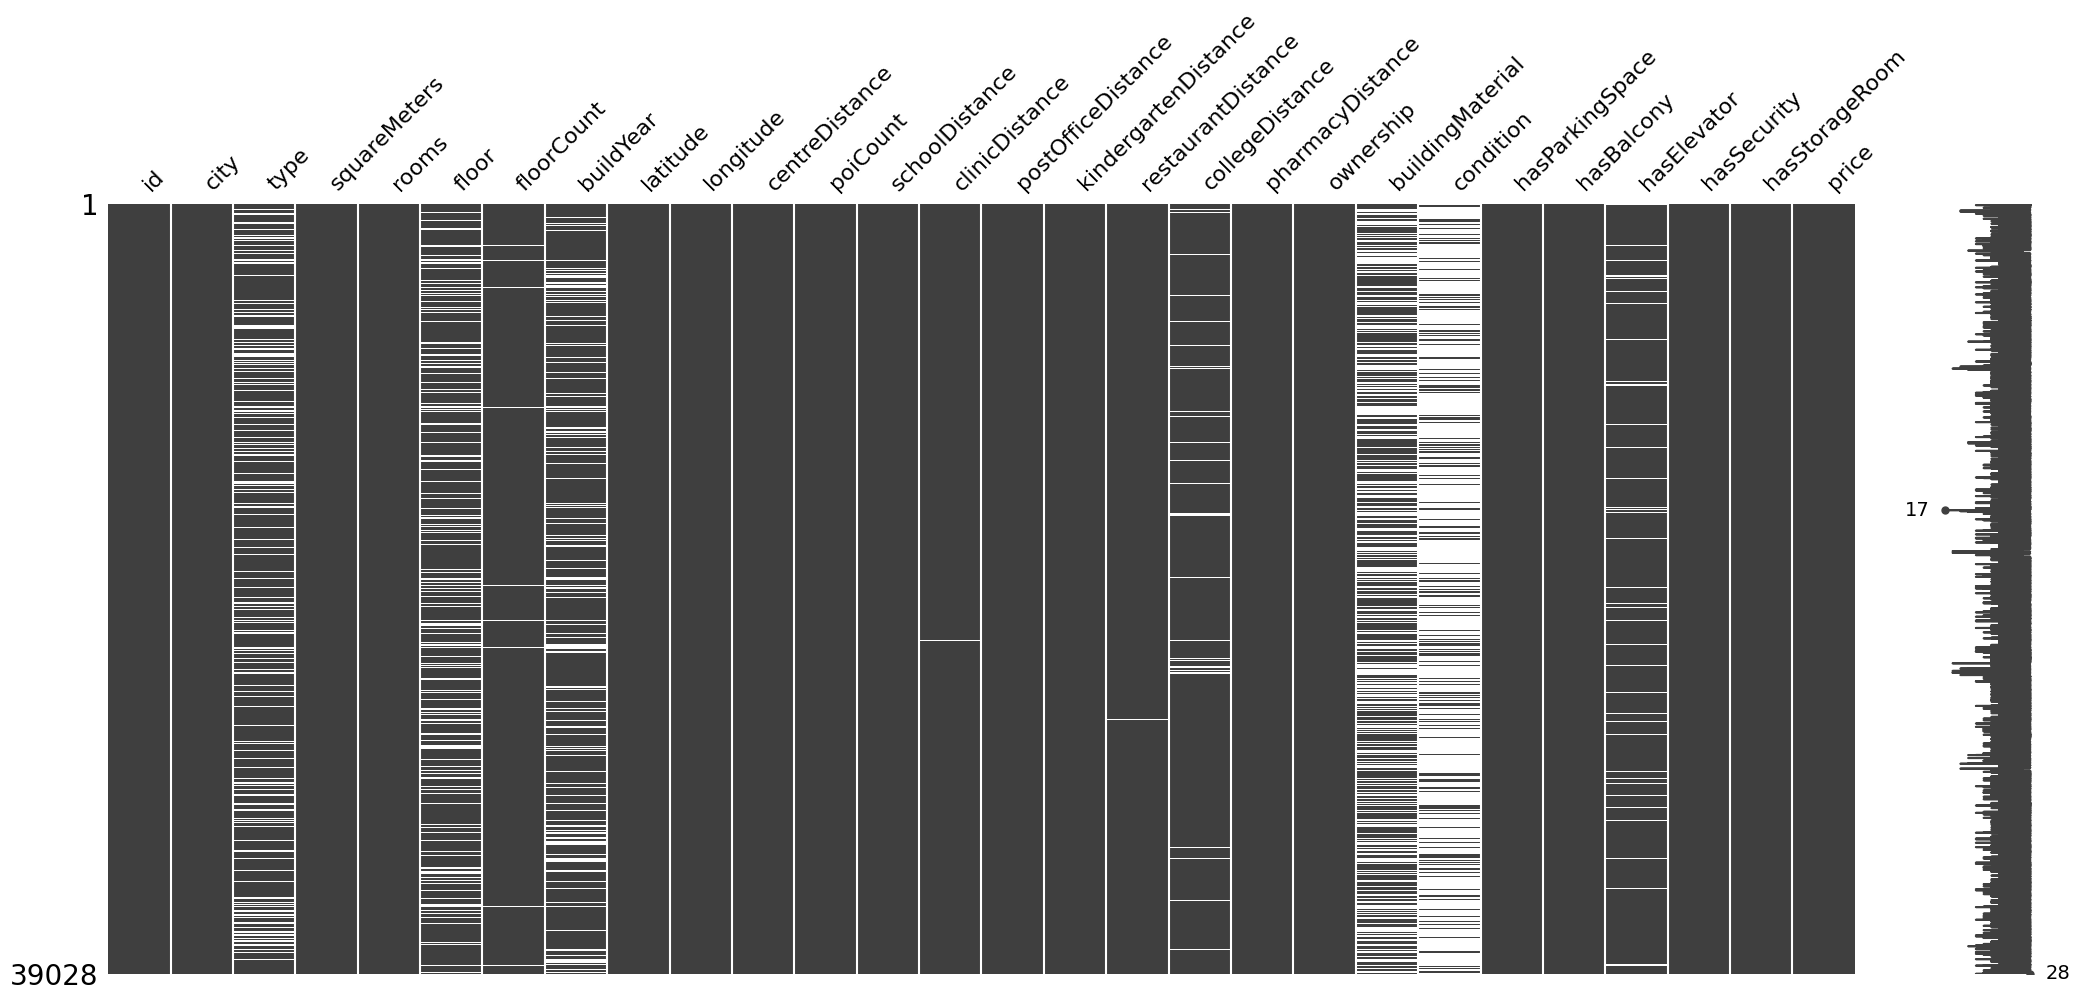

In [9]:
msno.matrix(df_apartments_2)

We can see missing values randomly distributed and some columns have high share of missing values

In [10]:
df_apartments_2.isna().sum().sort_values(ascending=False)/len(df_apartments_2) * 100

condition               75.591883
buildingMaterial        40.734857
type                    22.207133
floor                   17.700113
buildYear               17.274777
hasElevator              5.065594
collegeDistance          2.869735
floorCount               1.224762
clinicDistance           0.461207
restaurantDistance       0.281849
pharmacyDistance         0.156298
postOfficeDistance       0.122989
kindergartenDistance     0.092241
schoolDistance           0.081992
hasParkingSpace          0.000000
ownership                0.000000
hasSecurity              0.000000
hasStorageRoom           0.000000
hasBalcony               0.000000
id                       0.000000
city                     0.000000
poiCount                 0.000000
centreDistance           0.000000
longitude                0.000000
latitude                 0.000000
rooms                    0.000000
squareMeters             0.000000
price                    0.000000
dtype: float64

We've decided to delete 3 columns:
* id - it's a hash, so it doesnt hold any meaningful information
* "condition","buildingMaterial" - too many missing values

In [11]:
df_apartments_3 = df_apartments_2.drop(["id","condition","buildingMaterial"], axis=1) 

Let's look at the distribution of field types:

In [12]:
num_columns = list(df_apartments_3.select_dtypes("number").columns.values)
obj_columns = list(df_apartments_3.select_dtypes("object").columns.values)
print(len(num_columns), len(obj_columns), len(df_apartments.columns))

17 8 28


We can see that remaining columns are either numerical or strings - the latter ones can hopefully be turned into categories. However it must be checked first if there any nulls:

In [13]:
df_apartments_3[obj_columns].nunique()

city               15
type                3
ownership           3
hasParkingSpace     2
hasBalcony          2
hasElevator         2
hasSecurity         2
hasStorageRoom      2
dtype: int64

In [14]:
df_apartments_3[obj_columns].isna().sum().sort_values(ascending=False)/len(df_apartments_3) * 100

type               22.207133
hasElevator         5.065594
city                0.000000
ownership           0.000000
hasParkingSpace     0.000000
hasBalcony          0.000000
hasSecurity         0.000000
hasStorageRoom      0.000000
dtype: float64

We're going to replace missing values with constant value 'Other':

In [15]:
df_apartments_3.loc[df_apartments_3['type'].isna(),['type']]='Other'
df_apartments_3.loc[df_apartments_3['hasElevator'].isna(),['hasElevator']]='Other'

And now no missing values are present so we can turn object types into categorical:

In [16]:
df_apartments_3[obj_columns].isna().sum().sort_values(ascending=False)/len(df_apartments) * 100

city               0.0
type               0.0
ownership          0.0
hasParkingSpace    0.0
hasBalcony         0.0
hasElevator        0.0
hasSecurity        0.0
hasStorageRoom     0.0
dtype: float64

In [17]:
df_apartments_3[df_apartments_3.select_dtypes("object").columns.to_list()]  = df_apartments_3[df_apartments_3.select_dtypes("object").columns.to_list()].astype('category')
df_apartments_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39028 entries, 0 to 68893
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   city                  39028 non-null  category
 1   type                  39028 non-null  category
 2   squareMeters          39028 non-null  float64 
 3   rooms                 39028 non-null  float64 
 4   floor                 32120 non-null  float64 
 5   floorCount            38550 non-null  float64 
 6   buildYear             32286 non-null  float64 
 7   latitude              39028 non-null  float64 
 8   longitude             39028 non-null  float64 
 9   centreDistance        39028 non-null  float64 
 10  poiCount              39028 non-null  float64 
 11  schoolDistance        38996 non-null  float64 
 12  clinicDistance        38848 non-null  float64 
 13  postOfficeDistance    38980 non-null  float64 
 14  kindergartenDistance  38992 non-null  float64 
 15  restaur

All transformations on apartments dataframe are finished now, so we can save the file as input for running ML

In [18]:
df_apartments_3.to_csv("processed/apartments.csv")

Our categorical features don't have any missing values but there are several numerical columns with missing values

In [19]:
df_apartments_3.isna().sum().sort_values(ascending=False)/len(df_apartments_3) * 100

floor                   17.700113
buildYear               17.274777
collegeDistance          2.869735
floorCount               1.224762
clinicDistance           0.461207
restaurantDistance       0.281849
pharmacyDistance         0.156298
postOfficeDistance       0.122989
kindergartenDistance     0.092241
schoolDistance           0.081992
hasStorageRoom           0.000000
hasSecurity              0.000000
hasElevator              0.000000
hasBalcony               0.000000
hasParkingSpace          0.000000
ownership                0.000000
city                     0.000000
type                     0.000000
poiCount                 0.000000
centreDistance           0.000000
longitude                0.000000
latitude                 0.000000
rooms                    0.000000
squareMeters             0.000000
price                    0.000000
dtype: float64

They missng will be imputed with KNN Imputer. We'll use get_dummies to produce One Hot Encoding for categorical data to make imputing relying on all available data. 

In [20]:
df_apartments_4 = pd.get_dummies(df_apartments_3)

In [21]:
impKNN = KNNImputer(n_neighbors=5)

In [22]:
target = config['sources']['apartments']['target']
X = df_apartments_4.drop(target, axis=1)
y = df_apartments_4[target]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=12)
num_columns.remove(target)

ImputeKNN requires data scaling:

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [24]:
X_train_full = pd.DataFrame(impKNN.fit_transform(X_train_scaled), columns = X_train_scaled.columns)
X_test_full= pd.DataFrame(impKNN.transform(X_test_scaled), columns = X_test_scaled.columns)

We can see there is no missing data in the final dataset:

In [25]:
X_train_full[num_columns].isna().sum().sort_values(ascending=False)/len(df_apartments) * 100

squareMeters            0.0
rooms                   0.0
floor                   0.0
floorCount              0.0
buildYear               0.0
latitude                0.0
longitude               0.0
centreDistance          0.0
poiCount                0.0
schoolDistance          0.0
clinicDistance          0.0
postOfficeDistance      0.0
kindergartenDistance    0.0
restaurantDistance      0.0
collegeDistance         0.0
pharmacyDistance        0.0
dtype: float64

Let's check correlations:

In [26]:
correlations_num = X_train_full[num_columns].corr().abs()
mask = np.triu(np.ones_like(correlations_num, dtype=bool))
tri_df = correlations_num.mask(mask)
cor_limit = 0.6
to_drop = [c for c in tri_df.columns if any(tri_df[c] > cor_limit)]

Following features seam to be highly correlated with other and are candidates to be dropped:

In [27]:
print(to_drop)

['squareMeters', 'floor', 'schoolDistance', 'postOfficeDistance', 'kindergartenDistance', 'restaurantDistance']


Let's confirm it on the heatmap:

<Axes: >

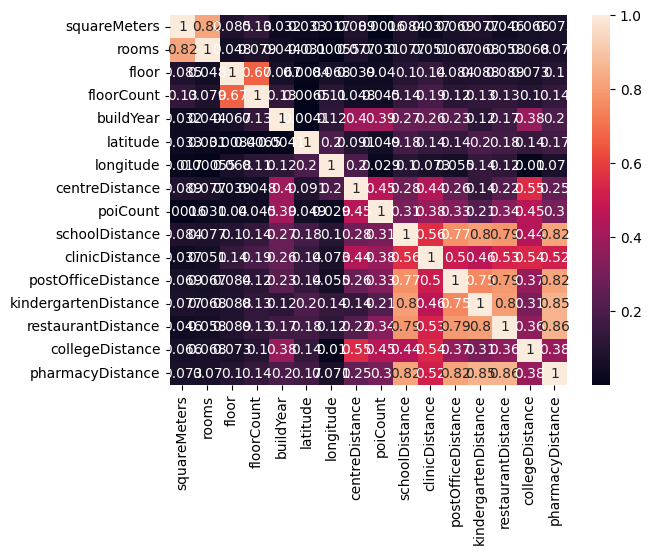

In [28]:
sns.heatmap(correlations_num, xticklabels = num_columns, yticklabels = num_columns, annot = True)


We can tell that 'squareMeters' and 'floor' are strongly correlated, but decided to keep squareMeters as more preceise measure. However, we decied to keep both 'floor' and 'floorCount' because they have different meaning despite being correlated.

In [29]:
X_train_full = X_train_full.drop("rooms", axis =1)
X_test_full = X_test_full.drop("rooms", axis =1)

## PCA

Similary we notice that all *Distance columns are more or less correlated and convienently are measured in the same unit, so we can replace them with surrogate features

In [30]:
cols_pca = ['schoolDistance', 'clinicDistance', 'postOfficeDistance', 'kindergartenDistance','restaurantDistance','collegeDistance','pharmacyDistance']
X_train_correlated = X_train_full[cols_pca]
X_test_correlated = X_test_full[cols_pca]

We expect new PCA components to provide 90% of variance explainability:

In [31]:
pca = PCA(n_components=0.9)
pc_X_train = pca.fit_transform(X_train_correlated)
pc_X_test = pca.transform(X_test_correlated)

We can see that number of features has been reduced from 7 to 4

In [32]:
pca.explained_variance_ratio_

array([0.68713604, 0.14215133, 0.06283199, 0.03603185])

And those features provide 92% vairance explainability

In [33]:
pca.explained_variance_ratio_.cumsum() #indeed >0.9

array([0.68713604, 0.82928737, 0.89211936, 0.92815122])

After adding new columns to the original dataset:

In [34]:
X_train_pca = pd.concat([X_train_full.drop(cols_pca, axis=1),pd.DataFrame(data=pc_X_train,columns=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))])], axis=1)
X_test_pca = pd.concat([X_test_full.drop(cols_pca, axis=1),pd.DataFrame(data=pc_X_test,columns=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))])], axis=1)

we see there are no specific correlations between numeric features:

<Axes: >

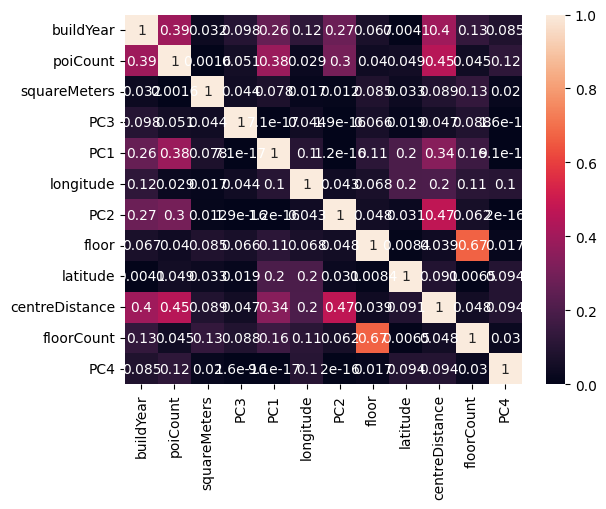

In [35]:
num_columns = list(set(num_columns).difference(set(cols_pca)).union(set([f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))])))
num_columns.remove('rooms')
correlations_num = X_train_pca[num_columns].corr().abs()
sns.heatmap(correlations_num, xticklabels = num_columns, yticklabels = num_columns, annot = True)

Variance

We can also confirm none of features is low in variance:

In [36]:
mask = X_train_pca.var()<0.1
print(any(mask)) 

False


Let's try to use this dataset to build ML model - it's mock run, to see if we get more or less sensible results

In [37]:
model1 = fit_transform_display(ens.RandomForestRegressor,X_train_pca, y_train, X_test_pca, y_test)

Model train score: 0.9860366305669506
Model test score: 0.903760132828042
RMSE: 105469.07071900483
MAPE: 0.09693833705005465


In the first attempt we received 10% percentage error with Random Forrest but model is overfitted (test score is lower than train score). Let's try with another set of parameters:

In [38]:
model2 = fit_transform_display(ens.RandomForestRegressor,X_train_pca, y_train, X_test_pca, y_test, {"max_depth" : 5, "n_estimators": 200, "n_jobs" : -1})

Model train score: 0.7426310883058315
Model test score: 0.7389388852559226
RMSE: 173707.55444871372
MAPE: 0.2055194741408427


Now model is (almost) not overfitted but it has worse results. Let's try to find best model systematically. For further analysis we'll use the processed file we saved earlier in 'processed' directory and apply following operations after each train/test split:
* Scaling
* Imputing missing values
* Creating PCA features for each case independently. For this purpose I created custom PCA Transformer that executes required transformations.
* Applying the chosen algoritm against given set of parameters

It's worth nothing that this time apply all operations after train/test split to avoid data leakage.

We are going to use the original dataset that we saved before One Hot Encoding and PCA

In [39]:
df = pd.read_csv('processed/apartments.csv')
target = config['sources']['apartments']['target']
pca_columns = config['sources']['apartments']['pca']['columns']
drop_columns = ['rooms']
to_drop = drop_columns + [target] #pca_columns + 
X = df.drop(to_drop, axis =1)
X_ohe = pd.get_dummies(X)
y = df[target]

In [44]:
pipeline = Pipeline(steps=[('scaling', StandardScaler(with_mean =False)),
                           ('missing',  KNNImputer(n_neighbors=5)),
                           ('pca', PCA_Transform(X_ohe.columns)),
                           ('rf',  ens.RandomForestRegressor())])    

In [49]:
grid = { 
    'rf__n_estimators': [200,400],
    'rf__max_depth' : [5,10,20],
    'rf__random_state' : [18]
}


We are going to use folds for cross-validation and MAPE as scoring criterion

In [52]:
random_grid = RandomizedSearchCV(pipeline,param_distributions =grid, cv=3,scoring = 'neg_mean_absolute_percentage_error', n_jobs=4,return_train_score =True, verbose=True) 
random_grid.fit(X_ohe, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/home/piotr/projects/ml-project/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaling',
                                              StandardScaler(with_mean=False)),
                                             ('missing', KNNImputer()),
                                             ('pca',
                                              PCA_Transform(all_columns=Index(['Unnamed: 0', 'squareMeters', 'floor', 'floorCount', 'buildYear',
       'latitude', 'longitude', 'centreDistance', 'poiCount', 'schoolDistance',
       'clinicDistance', 'postOfficeDistance', 'kindergartenDistance',
       'r...
       'hasBalcony_yes', 'hasElevator_Other', 'hasElevator_no',
       'hasElevator_yes', 'hasSecurity_no', 'hasSecurity_yes',
       'hasStorageRoom_no', 'hasStorageRoom_yes'],
      dtype='object'))),
                                             ('rf', RandomForestRegressor())]),
                   n_jobs=4,
                   param_distributions={'rf__max_depth': [5, 10, 20],
                                        'rf__n_estimators': [200, 400],
                                        'rf__random_state': [18]},
                   return_train_score=True,
                   scoring='neg_mean_absolute_percentage_error', verbose=True)

In [53]:
best_run(random_grid.cv_results_)

Number of not overfitted results 4
Best result:
Train: -0.1027061293460259
Test:-0.13348590966437635
Best params: {'rf__random_state': 18, 'rf__n_estimators': 400, 'rf__max_depth': 10}


{'rf__random_state': 18, 'rf__n_estimators': 400, 'rf__max_depth': 10}

As we can see we managed to reduce our percentage error to 13%. 

## Feature selection 

Feature selection based on Permutation Importance (MDA). Let's build the regression model based on best parameters and temporary split we created earlier

In [57]:
best_model = fit_transform_display(ens.RandomForestRegressor,X_train_pca, y_train, X_test_pca, y_test, {"max_depth" : 10, "n_estimators": 400, "n_jobs" : -1})

Model train score: 0.9248739952105106
Model test score: 0.8842939629738824
RMSE: 115644.67010648844
MAPE: 0.1169427561587993


In [59]:
r = permutation_importance(best_model, X_test_pca,y_test,n_repeats=10,random_state=17)

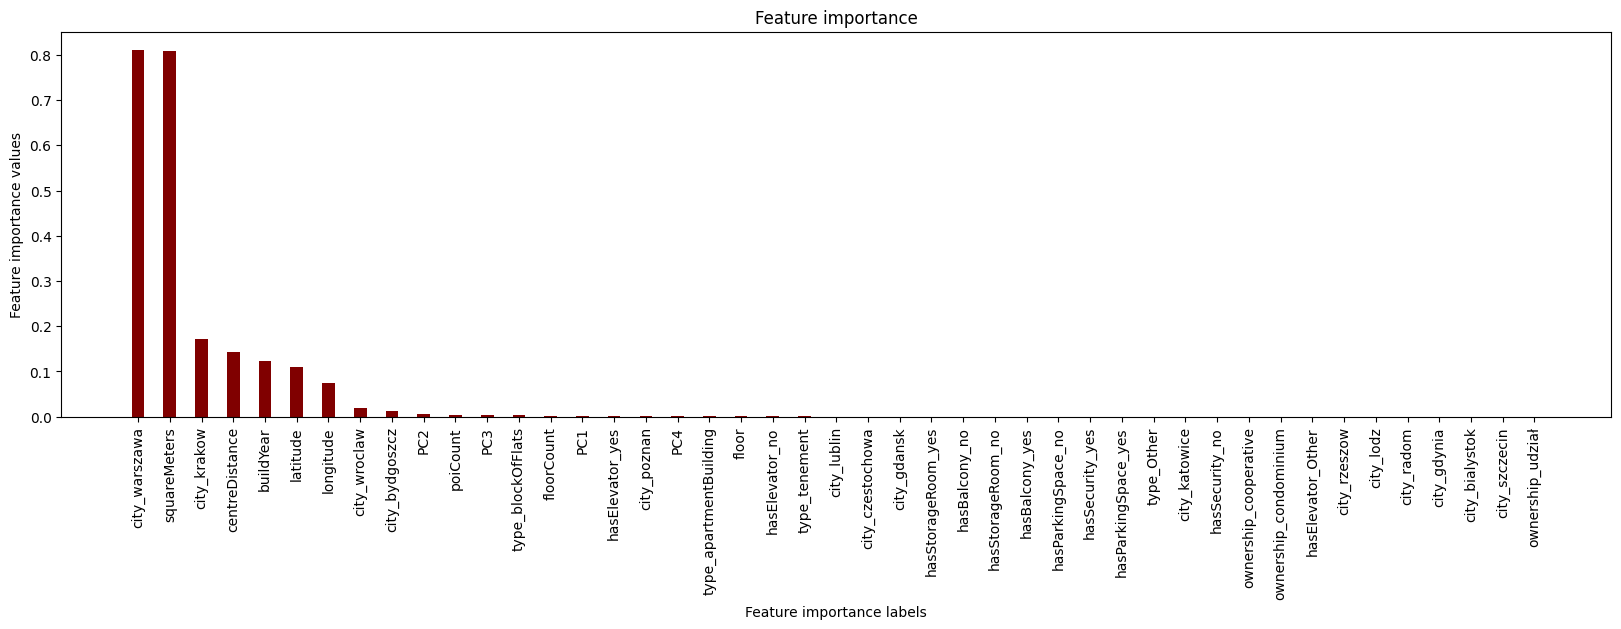

In [60]:
values = list(r['importances_mean'])
mapping = list(zip(X_test_pca.columns,values))
mapping.sort(key=lambda x: x[1], reverse=True)
mapping = dict(mapping)
fig = plt.figure(figsize = (20,5))
plt.bar(mapping.keys(), mapping.values(), color='maroon', width = 0.4)
plt.xlabel("Feature importance labels")
plt.xticks(rotation='vertical')
plt.ylabel("Feature importance values")
plt.title("Feature importance")
plt.show()

Based on the permutation importance criterion we're choosing following columns:

In [41]:

selected_columns = ['city','squareMeters','centreDistance','buildYear','latitude','longitude']

In [63]:
df = pd.read_csv('processed/apartments.csv')
target = config['sources']['apartments']['target']
X_sel = X[selected_columns]
X_ohe = pd.get_dummies(X_sel)
y = df[target]

In [64]:
pipeline = Pipeline(steps=[('scaling', StandardScaler(with_mean =False)),
                           ('missing',  KNNImputer(n_neighbors=5)),
                           ('rf',  ens.RandomForestRegressor())])    
grid = { 
    'rf__n_estimators': [200,300,400],
    'rf__max_depth' : [5,7,9,10,12,20],
    'rf__random_state' : [18]
}


In [65]:
random_grid = RandomizedSearchCV(pipeline,param_distributions =grid, cv=3,scoring = 'neg_mean_absolute_percentage_error', n_jobs=-1,return_train_score =True, verbose=True) 
random_grid.fit(X_ohe, y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaling',
                                              StandardScaler(with_mean=False)),
                                             ('missing', KNNImputer()),
                                             ('rf', RandomForestRegressor())]),
                   n_jobs=-1,
                   param_distributions={'rf__max_depth': [5, 7, 9, 10, 12, 20],
                                        'rf__n_estimators': [200, 300, 400],
                                        'rf__random_state': [18]},
                   return_train_score=True,
                   scoring='neg_mean_absolute_percentage_error', verbose=True)

In [67]:
best_run(random_grid.cv_results_)

Number of not overfitted results 8
Best result:
Train: -0.08477464565233488
Test:-0.12250546525586892
Best params: {'rf__random_state': 18, 'rf__n_estimators': 400, 'rf__max_depth': 12}


{'rf__random_state': 18, 'rf__n_estimators': 400, 'rf__max_depth': 12}

With limited number of features the quality of the model is not only not worse, but a actually better (MAPE 12%)

However, this result was achieved by using data with One Hot Encoding applied to all observations, before Train/Test split, which resulted in potential data leakage. Therefore we need to replace panda's get_dummy with sklearn's OneHotEncoder and include this step in the sklearn Pipeline. 

In [101]:
df = pd.read_csv('processed/apartments.csv')
target = config['sources']['apartments']['target']
X_sel = X[selected_columns]
y = df[target]
X_sel_sample = X[selected_columns].sample(frac=0.3)
y_sample = df.loc[X_sel_sample.index,target]
cat_cols = ['city']
num_cols = ['squareMeters','centreDistance','buildYear','latitude','longitude']

Unfortunately the processing crashed multiple times for full dataset (30k observations), but fortunately it was feasible with 30% random sample

In [93]:
from sklearn.compose import ColumnTransformer
preprocess = ColumnTransformer([('cat_cols', OneHotEncoder(sparse_output = False, dtype = np.uint8), cat_cols),
                                ('num_cols', StandardScaler(), num_cols)])

In [99]:
pipeline = Pipeline(steps=[('preproces',preprocess),
                           ('missing',  KNNImputer(n_neighbors=5)),
                           ('rf',  ens.RandomForestRegressor())])    
grid = { 
    'rf__n_estimators': [200,400,600],
    'rf__max_depth' : [5,10,15,20],
    'rf__random_state' : [18]
}


In [102]:
random_grid = GridSearchCV(pipeline,param_grid=grid, cv=3,scoring = 'neg_mean_absolute_percentage_error', n_jobs=-1,return_train_score =True, verbose=True) 
random_grid.fit(X_sel_sample, y_sample)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preproces',
                                        ColumnTransformer(transformers=[('cat_cols',
                                                                         OneHotEncoder(dtype=<class 'numpy.uint8'>,
                                                                                       sparse_output=False),
                                                                         ['city']),
                                                                        ('num_cols',
                                                                         StandardScaler(),
                                                                         ['squareMeters',
                                                                          'centreDistance',
                                                                          'buildYear',
                                                                          'latitude',
                                                                          'longitude'])])),
                                       ('missing', KNNImputer()),
                                       ('rf', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [5, 10, 15, 20],
                         'rf__n_estimators': [200, 400, 600],
                         'rf__random_state': [18]},
             return_train_score=True,
             scoring='neg_mean_absolute_percentage_error', verbose=True)

In [103]:
best_run(random_grid.cv_results_)

Number of not overfitted results 6
Best result:
Train: -0.09427116902082515
Test:-0.12755501485935325
Best params: {'rf__max_depth': 10, 'rf__n_estimators': 400, 'rf__random_state': 18}


{'rf__max_depth': 10, 'rf__n_estimators': 400, 'rf__random_state': 18}

We can see result close to the best achieved earlier, so let's try fine-tuning the parameters further:

In [104]:
pipeline = Pipeline(steps=[('preproces',preprocess),                          
                           ('missing',  KNNImputer(n_neighbors=5)),
                           ('rf',  ens.RandomForestRegressor())])    
grid = { 
    'rf__n_estimators': [350,375,400,425,450],
    'rf__max_depth' : [5,7,10,12,15],
    'rf__random_state' : [18]
}

In [105]:
random_grid = GridSearchCV(pipeline,param_grid=grid, cv=3,scoring = 'neg_mean_absolute_percentage_error', n_jobs=-1,return_train_score =True, verbose=True) 
random_grid.fit(X_sel_sample, y_sample)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preproces',
                                        ColumnTransformer(transformers=[('cat_cols',
                                                                         OneHotEncoder(dtype=<class 'numpy.uint8'>,
                                                                                       sparse_output=False),
                                                                         ['city']),
                                                                        ('num_cols',
                                                                         StandardScaler(),
                                                                         ['squareMeters',
                                                                          'centreDistance',
                                                                          'buildYear',
                                                                          'latitude',
                                                                          'longitude'])])),
                                       ('missing', KNNImputer()),
                                       ('rf', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [5, 7, 10, 12, 15],
                         'rf__n_estimators': [350, 375, 400, 425, 450],
                         'rf__random_state': [18]},
             return_train_score=True,
             scoring='neg_mean_absolute_percentage_error', verbose=True)

In [106]:
best_run(random_grid.cv_results_)

Number of not overfitted results 20
Best result:
Train: -0.07413384146116377
Test:-0.12364699002723205
Best params: {'rf__max_depth': 12, 'rf__n_estimators': 375, 'rf__random_state': 18}


{'rf__max_depth': 12, 'rf__n_estimators': 375, 'rf__random_state': 18}

As we can see our final model MAPE is 12.3% which we find acceptable at this time.